## Task 4 : Image Reconstruction using Matrix Factorisation [4 Marks]

Use the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorisation, and solve the following questions. Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.

1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank $r$. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics.  **[1 Marks]**

2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.**[3 Marks]**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/var/folders/p3/184hg1h95psd8k39s1mht5jw0000gn/T/ipykernel_11595/794610664.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
img = torchvision.io.read_image("/Users/sohamshrivastava/Library/CloudStorage/OneDrive-iitgn.ac.in/disk D items iii/college/semester 3/Machine learning/Assignment 2/es335-24-fall-assignment-2/sample.jpeg")
print(img.shape)

torch.Size([3, 1600, 1200])


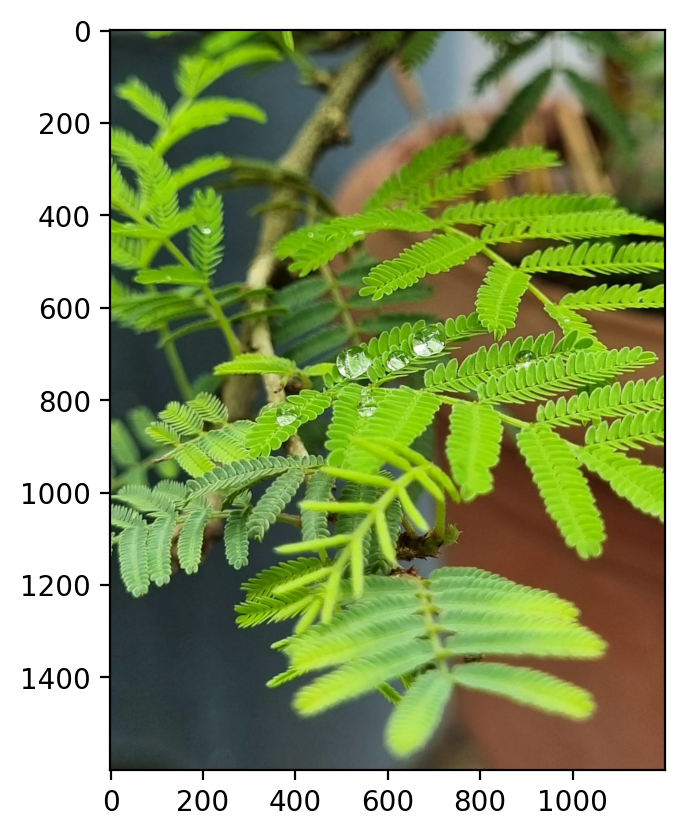

In [3]:
img_permuted = img.permute(1, 2, 0)
img_np = img_permuted.numpy()
plt.imshow(img_np)
plt.show()

In [4]:
crop = torchvision.transforms.functional.crop(img, 500, 300, 500, 500)
crop.shape

torch.Size([3, 500, 500])

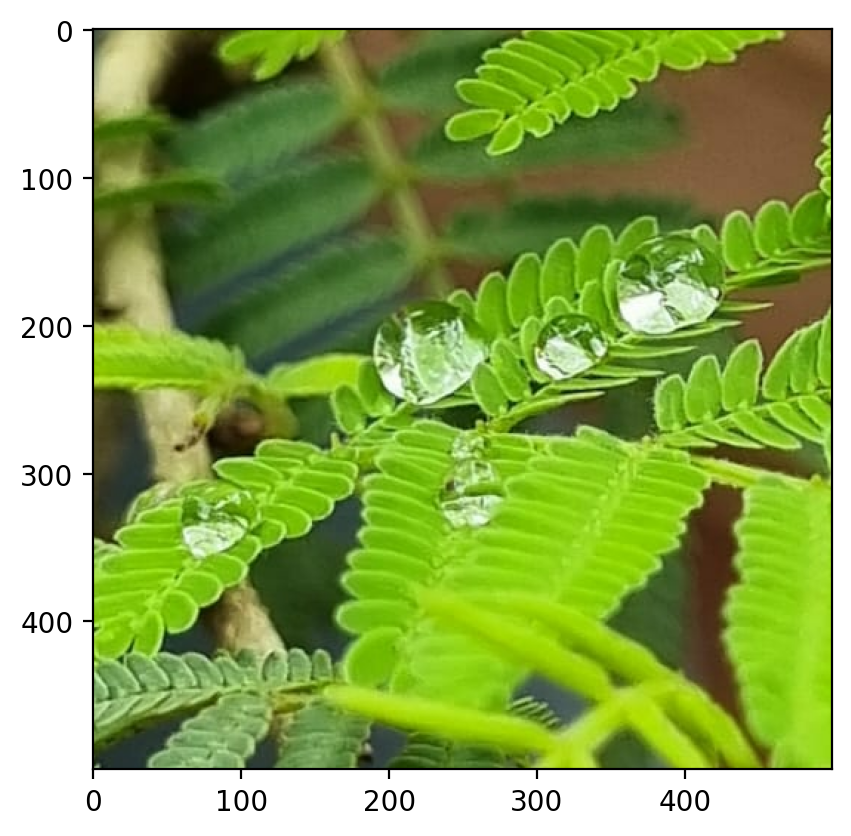

(500, 500, 3)


In [5]:
crop_permuted = crop.permute(1, 2, 0)
crop_np = crop_permuted.numpy()
plt.imshow(crop_np)
plt.show()
print(crop_np.shape)

Iteration 0, Loss: 299.9302978515625
Iteration 500, Loss: 0.0628986731171608
Iteration 1000, Loss: 0.03905753046274185
Iteration 1500, Loss: 0.028879452496767044
Iteration 2000, Loss: 0.023256152868270874
Iteration 2500, Loss: 0.019779926165938377
Iteration 3000, Loss: 0.017593633383512497
Iteration 3500, Loss: 0.01590394787490368
Iteration 4000, Loss: 0.014352807775139809
Iteration 4500, Loss: 0.012879918329417706


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


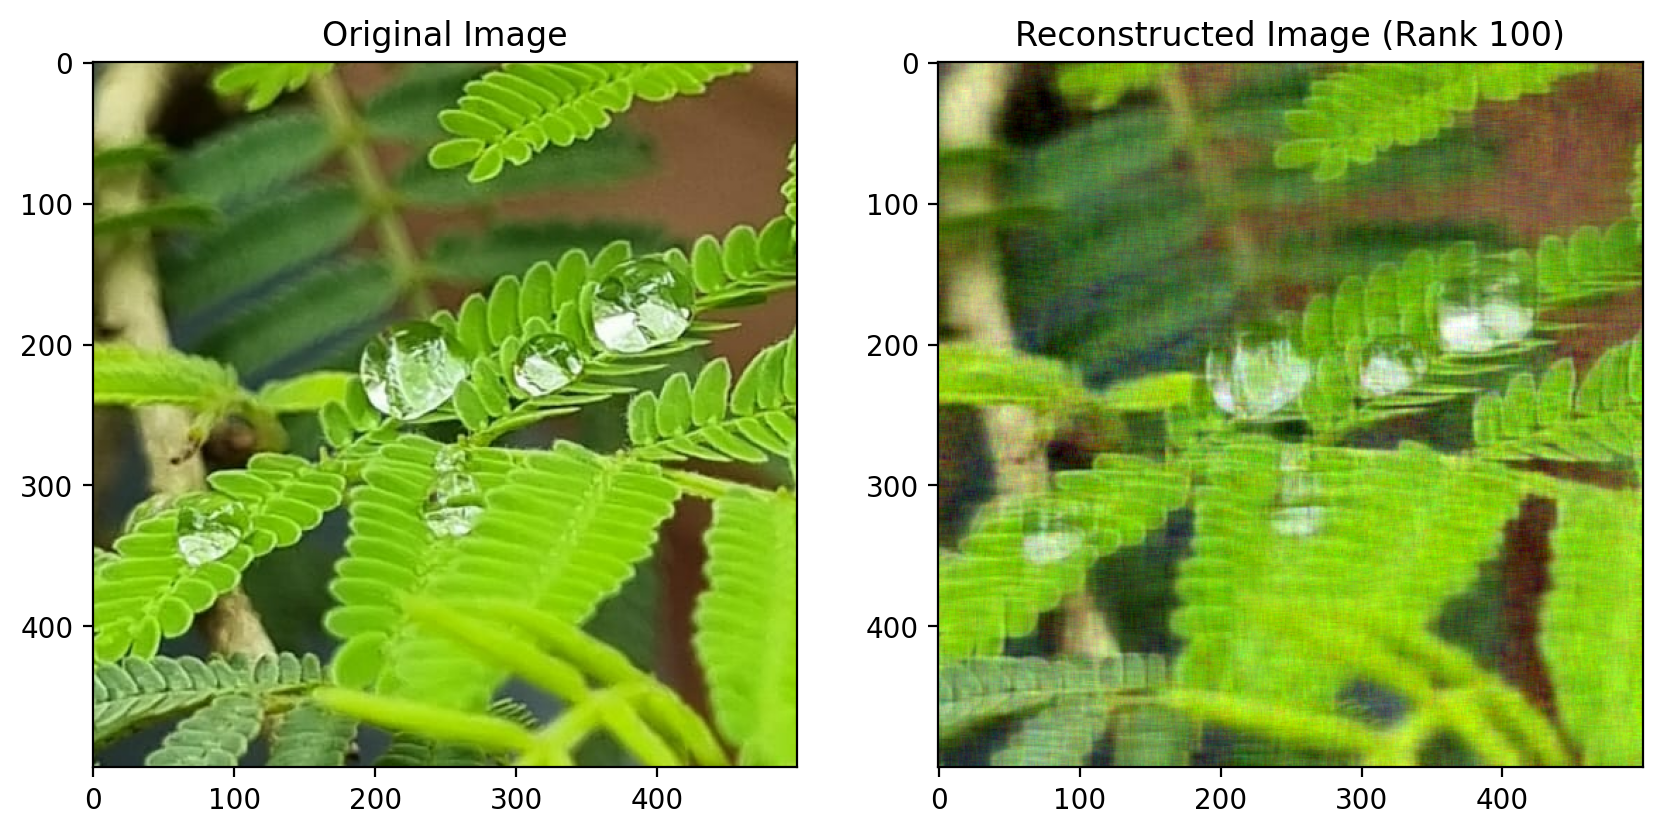

In [6]:
import torch
import torch.nn as nn
def matrix_factorization_gd(image_tensor, rank, lr=0.01, iterations=5000):
   
    C, H, W = image_tensor.shape
    U = [torch.randn(H, rank, requires_grad=True) for i in range(C)]
    V = [torch.randn(rank, W, requires_grad=True) for i in range(C)]
      
    optimizer = torch.optim.Adam(U + V, lr=lr)
    loss_fn = nn.MSELoss()
    for i in range(iterations):
        loss = 0
        optimizer.zero_grad()
        for c in range(C):
            reconstructed = U[c] @ V[c] 
            loss += loss_fn(reconstructed, image_tensor[c])
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    reconstructed_image = torch.stack([U[c] @ V[c] for c in range(C)])
    return reconstructed_image

crop = crop.float() / 255.0

rank = 100
reconstructed_image = matrix_factorization_gd(crop, rank, lr=1e-2, iterations=5000)

def plot_images(original, reconstructed):
    original_np = original.permute(1, 2, 0).detach().numpy()  
    reconstructed_np = reconstructed.permute(1, 2, 0).detach().numpy() 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_np)
    axes[0].set_title("Original Image")
    
    axes[1].imshow(reconstructed_np)
    axes[1].set_title(f"Reconstructed Image (Rank {rank})")
    plt.show()

plot_images(crop, reconstructed_image)


In [7]:
import torch
import numpy as np

def calculate_rmse(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)  
    rmse = torch.sqrt(mse)  
    return rmse

def calculate_psnr(original, reconstructed):
    rmse = calculate_rmse(original, reconstructed)
    if rmse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(1.0) / torch.tensor(rmse))
    return psnr

rmse_value = calculate_rmse(crop, reconstructed_image)
psnr_value = calculate_psnr(crop, reconstructed_image)

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")


RMSE: 0.061986275017261505
PSNR: 24.154088973999023


/var/folders/p3/184hg1h95psd8k39s1mht5jw0000gn/T/ipykernel_11595/184442234.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psnr = 20 * torch.log10(torch.tensor(1.0) / torch.tensor(rmse))


In [8]:
import torch
import numpy as np

def mask_block(image_tensor, block_size=(30, 30), top_left=None):
    C, H, W = image_tensor.shape
    block_height, block_width = block_size
    
    if top_left is None:
        top = np.random.randint(0, H - block_height + 1)
        left = np.random.randint(0, W - block_width + 1)
    else:
        top, left = top_left
    mask = torch.ones(H, W, dtype=torch.bool)
    mask[top:top + block_height, left:left + block_width] = False
    masked_image = image_tensor.clone()
    for c in range(C):
        masked_image[c] = torch.where(mask, image_tensor[c], torch.tensor(0.0))
    
    return masked_image, mask

masked_image, mask = mask_block(crop, block_size=(30, 30))




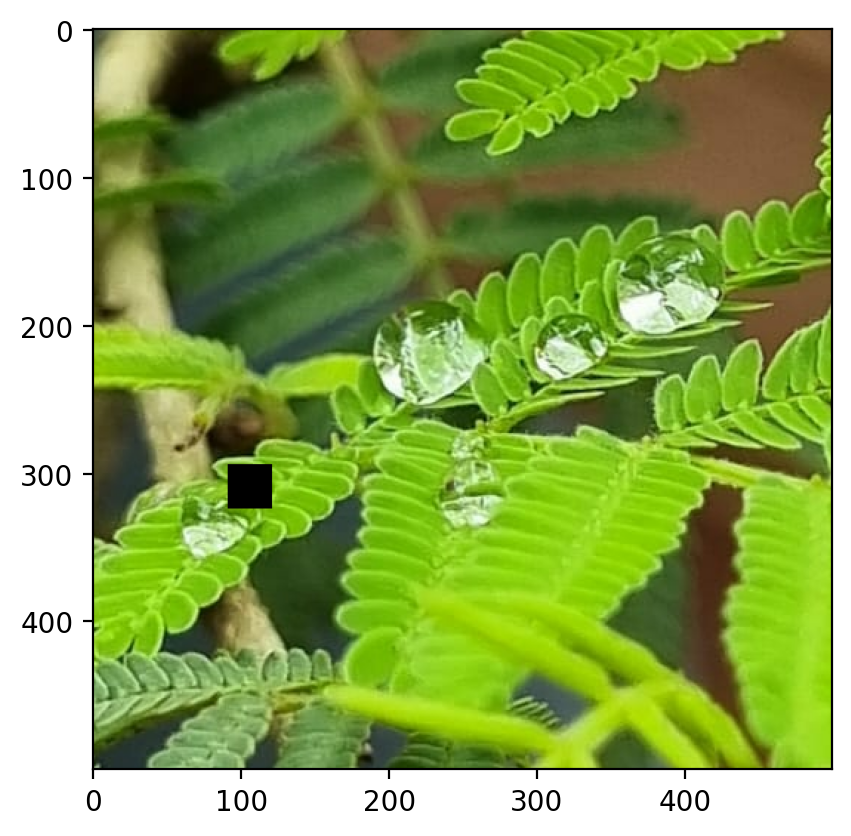

In [9]:

masked_np = masked_image.permute(1, 2, 0).detach().numpy()
plt.imshow(masked_np)

In [10]:
mask

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [11]:
import torch
import torch.nn as nn

def matrix_factorization_block(image_tensor, mask, rank, lr=0.01, iterations=5000):
    C, H, W = image_tensor.shape
    U = [torch.randn(H, rank, requires_grad=True) for _ in range(C)]
    V = [torch.randn(rank, W, requires_grad=True) for _ in range(C)]
    
    optimizer = torch.optim.Adam(U + V, lr=0.01)
    loss_fn = nn.MSELoss()

    for i in range(iterations):
        loss = 0
        optimizer.zero_grad()
        for c in range(C):
            reconstructed = U[c] @ V[c]
            masked_reconstructed = reconstructed[mask]
            masked_image = image_tensor[c][mask]
            loss += loss_fn(masked_reconstructed, masked_image)
        
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
            
    reconstructed_image = torch.stack([U[c] @ V[c] for c in range(C)])
    return reconstructed_image


In [12]:
rank = 100
reconstructed_image_block = matrix_factorization_block(crop, mask, rank, lr=0.01, iterations=5000)

Iteration 0, Loss: 298.3106689453125
Iteration 500, Loss: 0.06228481978178024
Iteration 1000, Loss: 0.038250863552093506
Iteration 1500, Loss: 0.02763937972486019
Iteration 2000, Loss: 0.022606201469898224
Iteration 2500, Loss: 0.019628610461950302
Iteration 3000, Loss: 0.017335768789052963
Iteration 3500, Loss: 0.015441138297319412
Iteration 4000, Loss: 0.01383313350379467
Iteration 4500, Loss: 0.01240158174186945


In [13]:
def plot_images(original, masked, reconstructed):
    original_np = original.permute(1, 2, 0).detach().numpy()
    masked_np = masked.permute(1, 2, 0).detach().numpy()
    reconstructed_np = reconstructed.permute(1, 2, 0).detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_np)
    axes[0].set_title("Original Image")
    
    axes[1].imshow(masked_np)
    axes[1].set_title("Masked Image (30x30 block missing)")

    axes[2].imshow(reconstructed_np)
    axes[2].set_title(f"Reconstructed Image (Rank {rank})")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


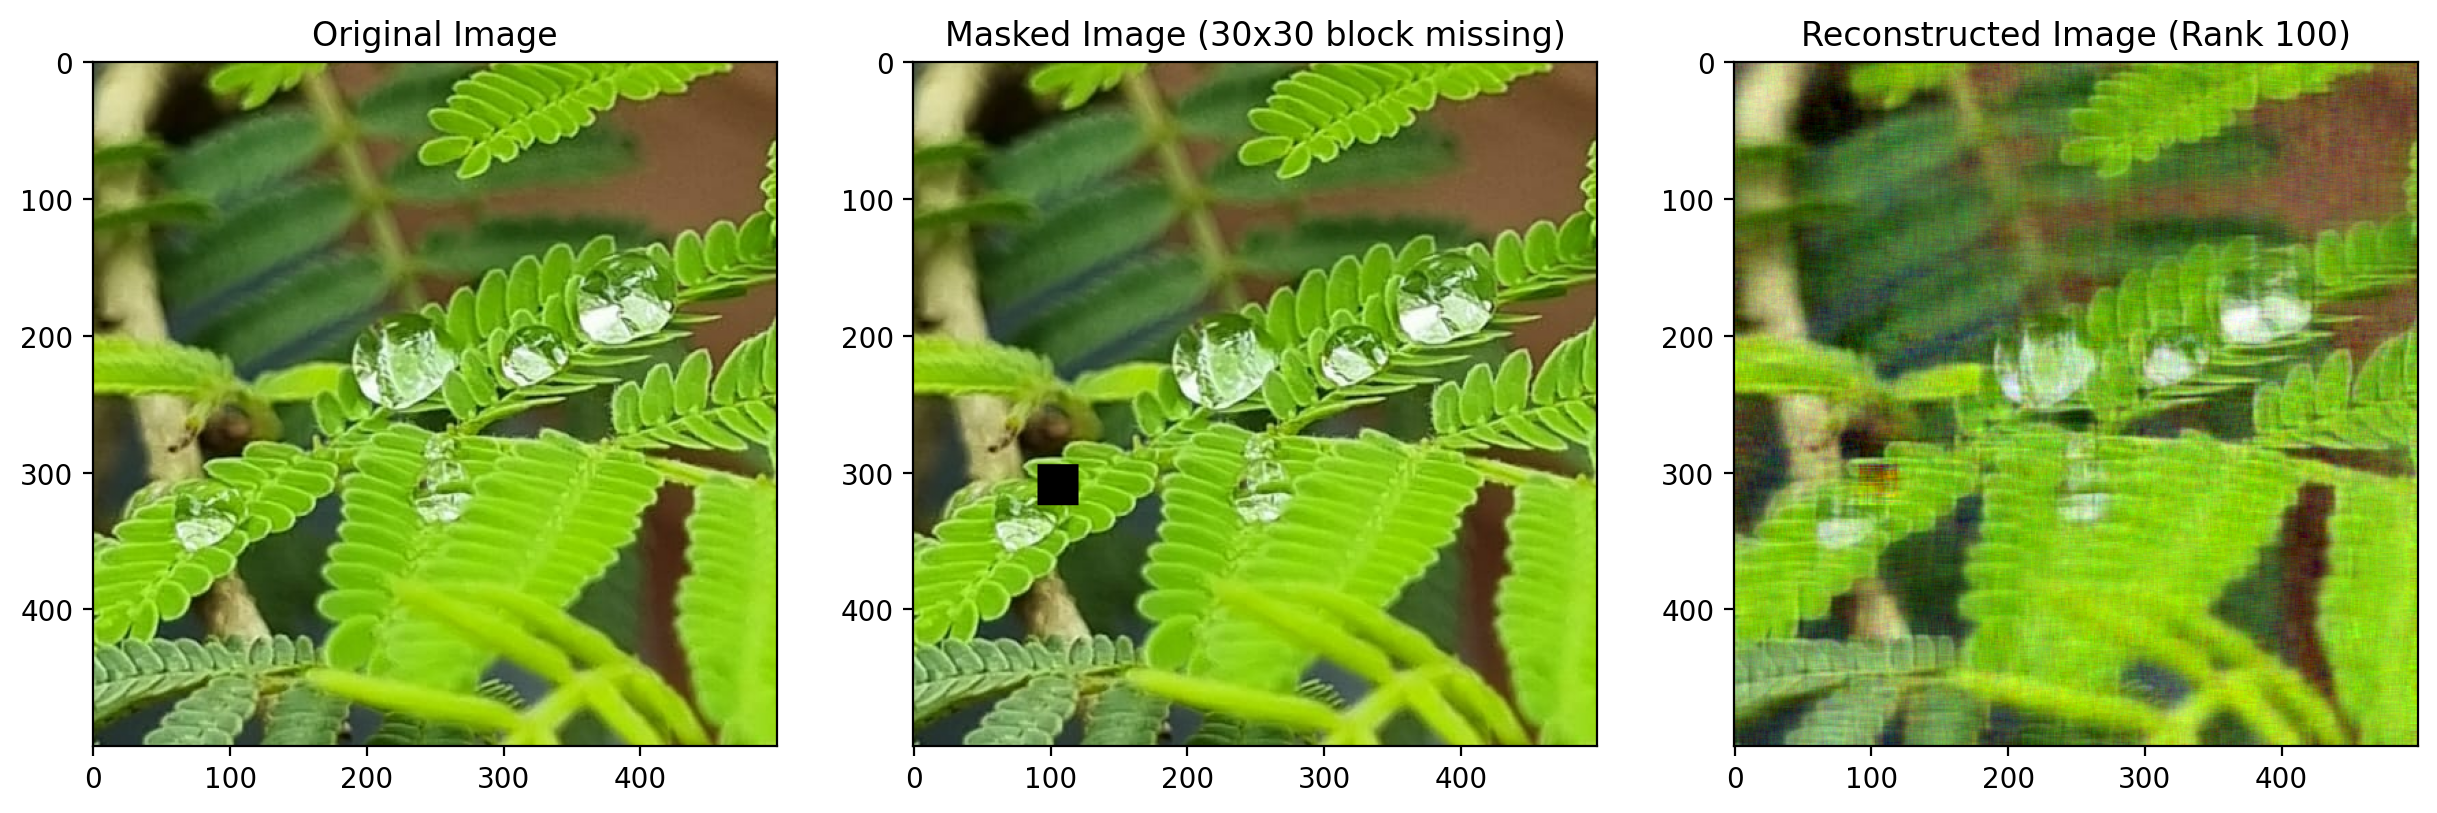

In [14]:
plot_images(crop, masked_image, reconstructed_image_block)

In [15]:
rmse_value_block = calculate_rmse(crop, reconstructed_image_block)
psnr_value_block = calculate_psnr(crop, reconstructed_image_block)

print(f"RMSE by Matrix Factorization: {rmse_value_block:.6f}")
print(f"PSNR by Matrix Factorization: {psnr_value_block:.6f} dB")


RMSE by Matrix Factorization: 0.061850
PSNR by Matrix Factorization: 24.173191 dB


/var/folders/p3/184hg1h95psd8k39s1mht5jw0000gn/T/ipykernel_11595/184442234.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psnr = 20 * torch.log10(torch.tensor(1.0) / torch.tensor(rmse))
